Notebook description: <br>

This notebook is created to analysis the kinematics data obtained after running the tracking code. <br>

Most of the tracking and analysis codes are written by Duncan and pieced together in this notebook.

### Import experiment (tracked and with kinematics data).

In [2]:
from behavior_analysis.experiment import  BehaviorExperiment
import pandas as pd
# Open experiment
experiment = BehaviorExperiment.open(r"C:\Users\manyung.ng\Documents\behaviour_analysis\behavior_analysis_tracking\uv_trial")
print(experiment)
# Open video and bout info
video_info = pd.read_csv(experiment.directory.joinpath('video_data.csv'), dtype={'ID': str, 'code': str})
bouts_df = pd.read_csv(experiment.subdirs["analysis"].joinpath('bouts.csv'),
                        dtype={'ID': str, 'code': str})

name: uv_trial
date: 2025-06-25
animal_data: fish_data.csv
video_data: video_data.csv
mask_data: mask_data.csv
bout_detection: {'threshold': 0.02, 'winsize': 0.05}



### Data information

- Fish ID in the format 'YYYYMMDDNN' (year, month, day, zero-padded fish number; e.g. fish_1 on 2025_05_29 would be 20250529) <br>

- Video code in the format 'IDHHMMSS' (fish_ID, hour, minute, second) <br>

- Number of rows == number of frames in the video

#### Description of data in the "kinematics/code + .csv"
| Column name | Column data description |
| --- | --- |
| 'k0' - 'k(n-1)' | angle of tangents between n successive tail points |
| 'tip' | the average curvature (tail angle) over the last 20% of the tail|
| 'length' | the length of the tail (useful for finding tracking errors) |
| 'left' | the angle of the left eye relative to the heading |
| 'right' | the angle of the right eye relative to the heading |
| 'speed' | the instantaneous speed in each frame |
| 'angular_velocity' | the instantaneous angular velocity in each frame |
| 'tracked' | whether kinematic data exists from the frame |

## Eye convergence analysis

Before running Duncan's analysis codes, let's check out what the eye angle looks like by simply plotting them out!

In [60]:
# load kinematics data
# example data info:
# fish: progeny of mafaa:QF2, ath5:Cre, QUAS:switchNTR outX (fish_3)
# condition: -NTR, +UV (no mafaa+ RGC ablation)
# videos: 250fps (unstable fps for this test recording), 2.5min each, 12 recordings (30min) in total

# 2nd video of the trial, no paramecia
test_kinematics_df1 = pd.read_csv(experiment.subdirs['kinematics'].joinpath("2025060603/2025060603163529.777.csv")).get(["speed", "angular_velocity","left_angle","right_angle"])
# 7th video of the trial, with paramecia
test_kinematics_df2 = pd.read_csv(experiment.subdirs['kinematics'].joinpath("2025060603/2025060603165036.654.csv")).get(["speed", "angular_velocity","left_angle","right_angle"])
# last video of the trial, with paramecia
test_kinematics_df3 = pd.read_csv(experiment.subdirs['kinematics'].joinpath("2025060603/2025060603170312.514.csv")).get(["speed", "angular_velocity","left_angle","right_angle"])
print(test_kinematics_df1, test_kinematics_df2)
test_kinematics_df3

           speed  angular_velocity  left_angle  right_angle
0       0.000000          0.437352   -0.348498     0.255398
1       0.000000          0.000000   -0.348498     0.255330
2       0.000000          0.000000   -0.348498     0.255261
3      50.370186          0.000000   -0.348427     0.254973
4      37.479958         -1.846830   -0.348357     0.254685
...          ...               ...         ...          ...
37514   0.000000          0.000000   -0.272642     0.373557
37515   0.000000          0.000000   -0.272642     0.373557
37516   0.000000          0.000000   -0.272983     0.373557
37517   0.000000          0.000000   -0.273324     0.373557
37518        NaN               NaN   -0.274786     0.373557

[37519 rows x 4 columns]             speed  angular_velocity  left_angle  right_angle
0        0.000000         -0.412235   -0.503180     0.509083
1      173.652289         -0.386430   -0.501629     0.508279
2       49.654356         -1.577967   -0.500078     0.507476
3       38

,speed,angular_velocity,left_angle,right_angle
0,121.090835,0.798119,1.339199,0.666944
1,0.000000,0.000000,1.339199,0.666944
2,66.768911,-0.197165,1.339199,0.666944
3,66.768911,0.000000,1.339385,0.672730
4,71.913803,2.301496,1.339571,0.678515
...,...,...,...,...
37513,293.871765,-1.112585,-0.476740,0.336004
37514,242.735831,-2.224339,-0.476188,0.336857
37515,190.391461,0.000000,-0.475939,0.336004
37516,166.392218,-0.157526,-0.475690,0.336857


In [14]:
# try plotting with seaborn
import seaborn as sns
# set figure size
sns.set_theme(rc={"figure.figsize": (20,5)})

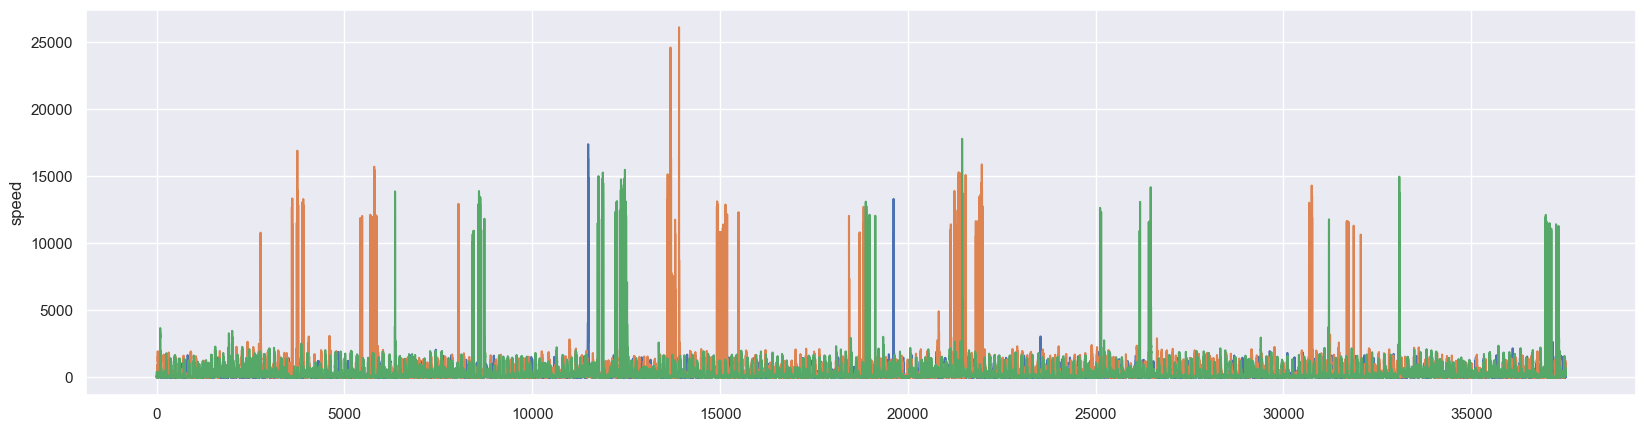

In [27]:
# check out the speed of the fish
sns.lineplot(data=test_kinematics_df1, x=test_kinematics_df1.index, y="speed") # in blue
sns.lineplot(data=test_kinematics_df2, x=test_kinematics_df2.index, y="speed") # in orange
sns.lineplot(data=test_kinematics_df3, x=test_kinematics_df3.index, y="speed") # in green

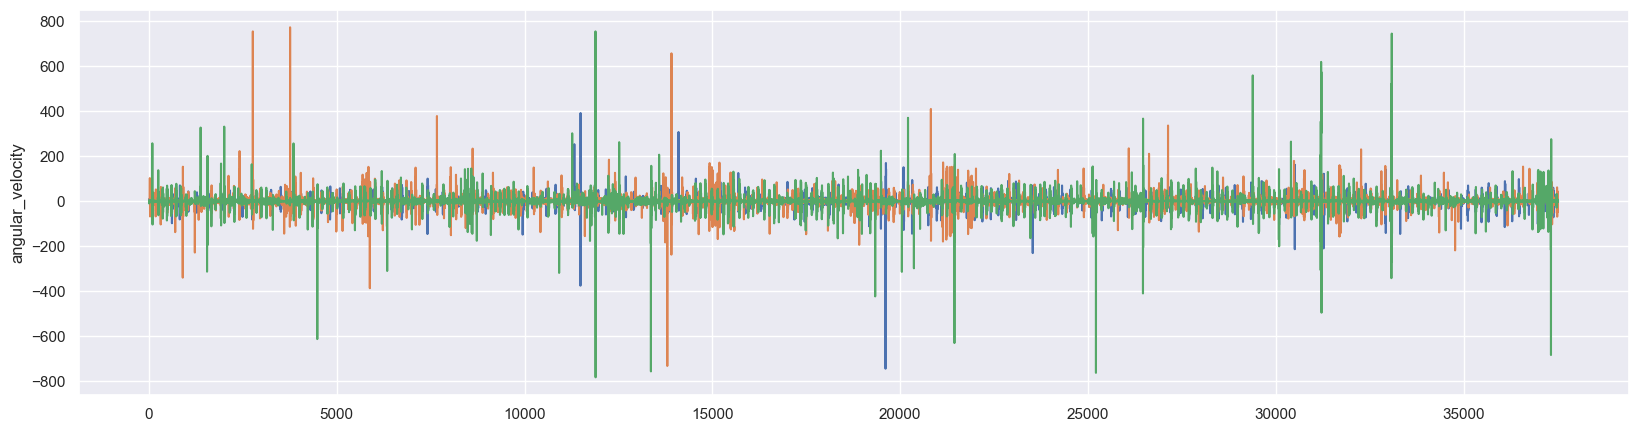

In [28]:
# check out the angular velocity of the fish
sns.lineplot(data=test_kinematics_df1, x=test_kinematics_df1.index, y="angular_velocity") # in blue
sns.lineplot(data=test_kinematics_df2, x=test_kinematics_df2.index, y="angular_velocity") # in orange
sns.lineplot(data=test_kinematics_df3, x=test_kinematics_df3.index, y="angular_velocity") # in green

In [61]:
# melt the df for plotting left and right eye angles at the same scale
test_kinematics_df1 = test_kinematics_df1.reset_index().rename(columns={'index': 'frame'}).melt( # reset_index and rename put the frame number (the original index) in a separate column
    id_vars= ['speed','angular_velocity','frame'], # these columns will be kept the same
    value_vars= ['left_angle','right_angle'], # these columns will be melted
    var_name= "direction", # the column name 'left_angle' and 'right_angle' will now label the angle degree in a separate column
    value_name= "angle (degree)" # the values of the 'left_angle' and 'right_angle' columns are now in one columns
)
test_kinematics_df1

,speed,angular_velocity,frame,direction,angle (degree)
0,0.000000,0.437352,0,left_angle,-0.348498
1,0.000000,0.000000,1,left_angle,-0.348498
2,0.000000,0.000000,2,left_angle,-0.348498
3,50.370186,0.000000,3,left_angle,-0.348427
4,37.479958,-1.846830,4,left_angle,-0.348357
...,...,...,...,...,...
75033,0.000000,0.000000,37514,right_angle,0.373557
75034,0.000000,0.000000,37515,right_angle,0.373557
75035,0.000000,0.000000,37516,right_angle,0.373557
75036,0.000000,0.000000,37517,right_angle,0.373557


In [62]:
# description same as above but for the second df
test_kinematics_df2 = test_kinematics_df2.reset_index().rename(columns={'index': 'frame'}).melt(
    id_vars= ['speed','angular_velocity','frame'],
    value_vars= ['left_angle','right_angle'],
    var_name= "direction",
    value_name= "angle (degree)"
)
test_kinematics_df2

,speed,angular_velocity,frame,direction,angle (degree)
0,0.000000,-0.412235,0,left_angle,-0.503180
1,173.652289,-0.386430,1,left_angle,-0.501629
2,49.654356,-1.577967,2,left_angle,-0.500078
3,38.210470,0.000000,3,left_angle,-0.501629
4,55.236978,0.981477,4,left_angle,-0.503180
...,...,...,...,...,...
75033,421.618773,0.000000,37514,right_angle,0.553456
75034,813.822525,-1.584844,37515,right_angle,0.559951
75035,359.950230,-3.431250,37516,right_angle,0.553456
75036,287.368239,-3.235960,37517,right_angle,0.546962


In [63]:
# description same as above but for the third df
test_kinematics_df3 = test_kinematics_df3.reset_index().rename(columns={'index': 'frame'}).melt( 
    id_vars= ['speed','angular_velocity','frame'],
    value_vars= ['left_angle','right_angle'],
    var_name= "direction",
    value_name= "angle (degree)"
)
test_kinematics_df3

,speed,angular_velocity,frame,direction,angle (degree)
0,121.090835,0.798119,0,left_angle,1.339199
1,0.000000,0.000000,1,left_angle,1.339199
2,66.768911,-0.197165,2,left_angle,1.339199
3,66.768911,0.000000,3,left_angle,1.339385
4,71.913803,2.301496,4,left_angle,1.339571
...,...,...,...,...,...
75031,293.871765,-1.112585,37513,right_angle,0.336004
75032,242.735831,-2.224339,37514,right_angle,0.336857
75033,190.391461,0.000000,37515,right_angle,0.336004
75034,166.392218,-0.157526,37516,right_angle,0.336857


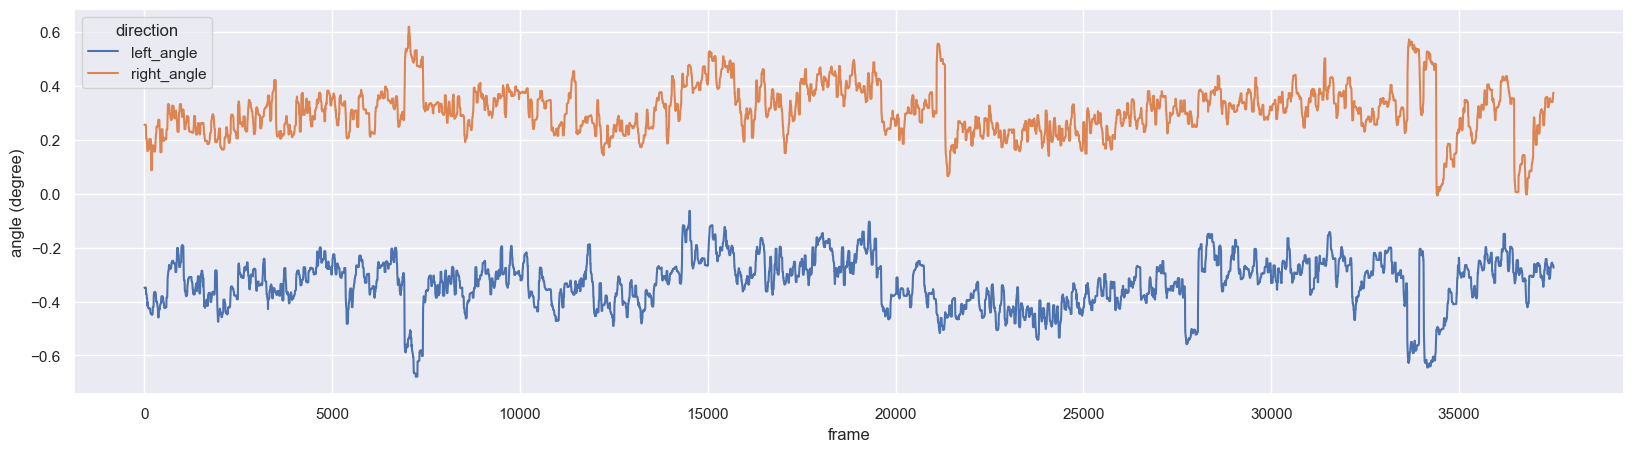

In [64]:
# at the beginning of trial, before introduction of paramecia
sns.lineplot(data=test_kinematics_df1, x='frame', y="angle (degree)", hue="direction", legend="auto")

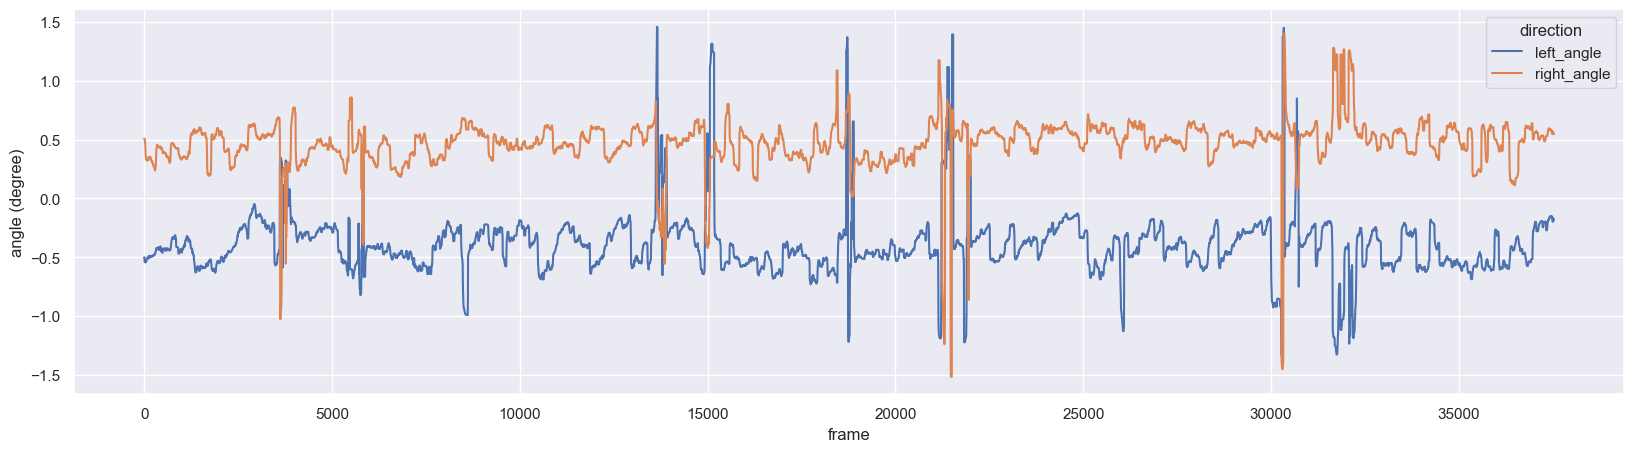

In [65]:
# in the middle of trial, after introduction of paramecia
sns.lineplot(data=test_kinematics_df2, x='frame', y="angle (degree)", hue="direction", legend="auto")

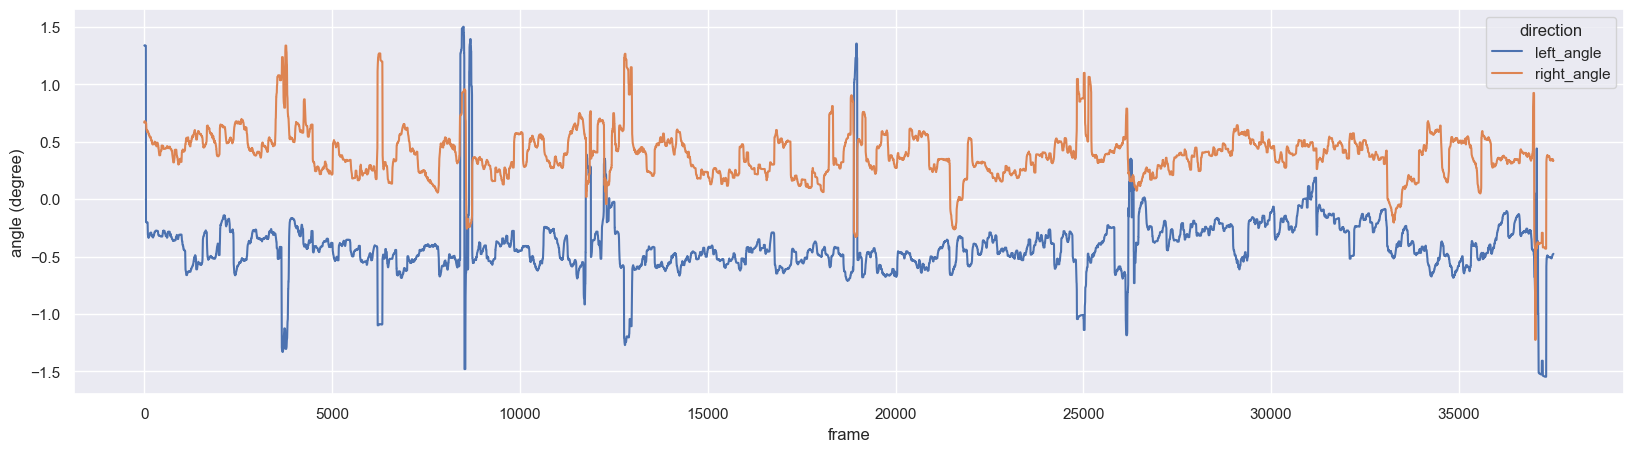

In [66]:
# at the end of the trial, after introduction of paramecia
sns.lineplot(data=test_kinematics_df3, x='frame', y="angle (degree)", hue="direction", legend="auto")

In [79]:
# load kinematics data
# example data info:
# fish: progeny of mafaa:QF2, ath5:Cre, QUAS:switchNTR outX (fish_2)
# condition: -NTR, -UV (no mafaa+ RGC ablation)
# videos: 250fps (unstable fps for this test recording), 2.5min each, 12 recordings (30min) in total

# 2nd video of the trial, no paramecia
test_kinematics_df1 = pd.read_csv(experiment.subdirs['kinematics'].joinpath("2025060602/2025060602155607.538.csv")).get(["speed", "angular_velocity","left_angle","right_angle"])
# 6th video of the trial, with paramecia
test_kinematics_df2 = pd.read_csv(experiment.subdirs['kinematics'].joinpath("2025060602/2025060602160612.354.csv")).get(["speed", "angular_velocity","left_angle","right_angle"])
# 2nd last video of the trial, with paramecia
test_kinematics_df3 = pd.read_csv(experiment.subdirs['kinematics'].joinpath("2025060602/2025060602162119.139.csv")).get(["speed", "angular_velocity","left_angle","right_angle"])
print(test_kinematics_df1, test_kinematics_df2)
test_kinematics_df3

           speed  angular_velocity  left_angle  right_angle
0      23.608352         -0.708200   -0.360542     0.301867
1       0.000000          0.000000   -0.360542     0.301867
2      23.524096          0.000000   -0.360542     0.301867
3      23.524096         -0.631283   -0.360542     0.301867
4       0.000000          1.044800   -0.360542     0.301867
...          ...               ...         ...          ...
37514   0.000000          0.000000   -0.345543     0.267685
37515   0.000000         -0.281302   -0.345543     0.267685
37516   0.000000          0.000000   -0.327871     0.267440
37517   0.000000          0.000000   -0.310199     0.267195
37518        NaN               NaN   -0.310199     0.267440

[37519 rows x 4 columns]             speed  angular_velocity  left_angle  right_angle
0        0.000000          0.000000   -0.620797     0.574335
1       40.862586          0.531859   -0.621167     0.576371
2       40.862586          0.000000   -0.621537     0.578406
3       78

,speed,angular_velocity,left_angle,right_angle
0,46.001546,-1.229085,-0.382583,0.147164
1,0.000000,0.000000,-0.380342,0.151202
2,42.286700,-1.906600,-0.378102,0.147164
3,30.040713,-0.726711,-0.376010,0.146804
4,0.000000,0.000000,-0.378102,0.146444
...,...,...,...,...
37512,55.065022,0.761609,-0.190090,0.238623
37513,60.014069,0.425378,-0.190090,0.238181
37514,0.000000,0.000000,-0.190903,0.236947
37515,183.602791,0.989245,-0.191716,0.235713


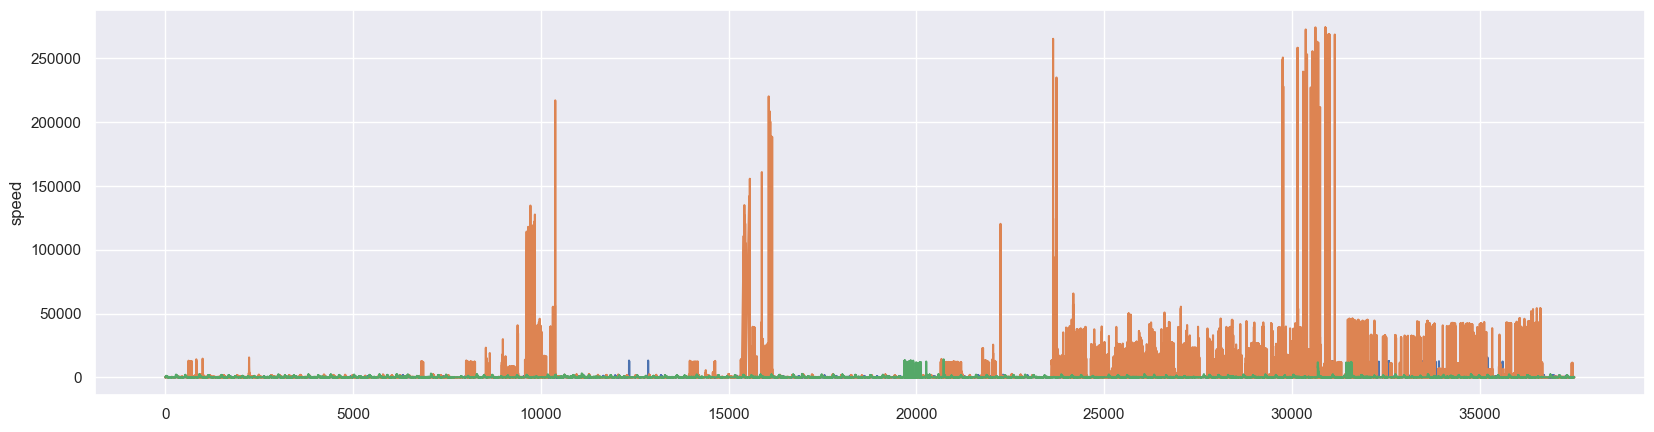

In [80]:
# check out the speed of the fish
sns.lineplot(data=test_kinematics_df1, x=test_kinematics_df1.index, y="speed") # in blue
sns.lineplot(data=test_kinematics_df2, x=test_kinematics_df2.index, y="speed") # in orange
sns.lineplot(data=test_kinematics_df3, x=test_kinematics_df3.index, y="speed") # in green

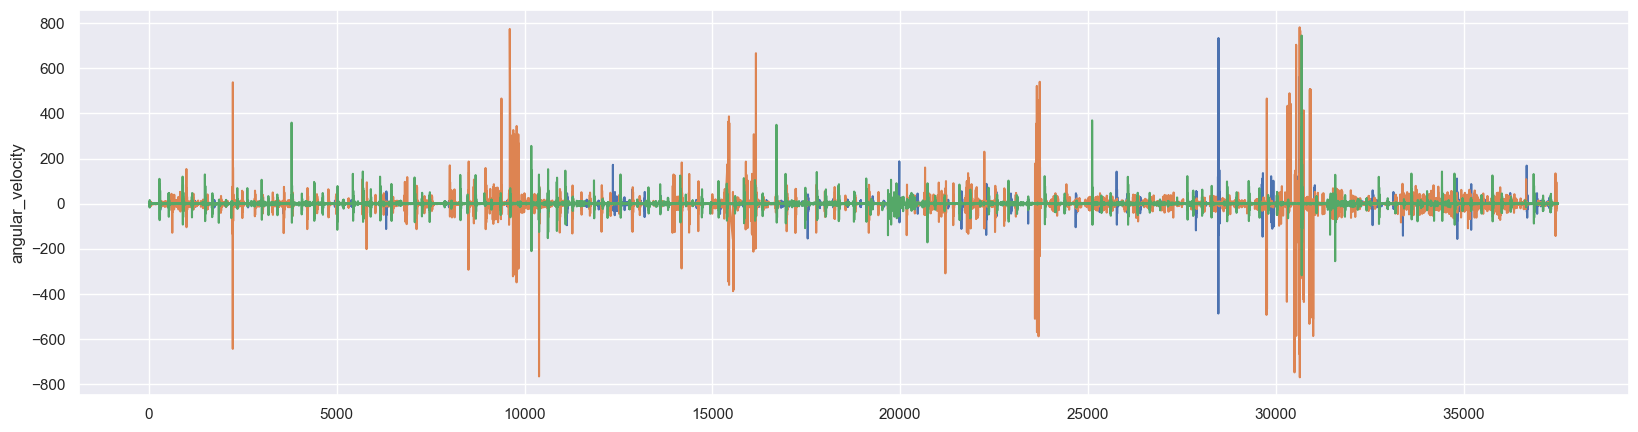

In [81]:
# check out the angular velocity of the fish
sns.lineplot(data=test_kinematics_df1, x=test_kinematics_df1.index, y="angular_velocity") # in blue
sns.lineplot(data=test_kinematics_df2, x=test_kinematics_df2.index, y="angular_velocity") # in orange
sns.lineplot(data=test_kinematics_df3, x=test_kinematics_df3.index, y="angular_velocity") # in green

In [82]:
# melt the df for plotting left and right eye angles at the same scale
test_kinematics_df1 = test_kinematics_df1.reset_index().rename(columns={'index': 'frame'}).melt( # reset_index and rename put the frame number (the original index) in a separate column
    id_vars= ['speed','angular_velocity','frame'],
    value_vars= ['left_angle','right_angle'],
    var_name= "direction",
    value_name= "angle (degree)"
)

test_kinematics_df2 = test_kinematics_df2.reset_index().rename(columns={'index': 'frame'}).melt( # reset_index and rename put the frame number (the original index) in a separate column
    id_vars= ['speed','angular_velocity','frame'],
    value_vars= ['left_angle','right_angle'],
    var_name= "direction",
    value_name= "angle (degree)"
)
test_kinematics_df3 = test_kinematics_df3.reset_index().rename(columns={'index': 'frame'}).melt( # reset_index and rename put the frame number (the original index) in a separate column
    id_vars= ['speed','angular_velocity','frame'],
    value_vars= ['left_angle','right_angle'],
    var_name= "direction",
    value_name= "angle (degree)"
)

test_kinematics_df3 # check if it's melted

,speed,angular_velocity,frame,direction,angle (degree)
0,46.001546,-1.229085,0,left_angle,-0.382583
1,0.000000,0.000000,1,left_angle,-0.380342
2,42.286700,-1.906600,2,left_angle,-0.378102
3,30.040713,-0.726711,3,left_angle,-0.376010
4,0.000000,0.000000,4,left_angle,-0.378102
...,...,...,...,...,...
75029,55.065022,0.761609,37512,right_angle,0.238623
75030,60.014069,0.425378,37513,right_angle,0.238181
75031,0.000000,0.000000,37514,right_angle,0.236947
75032,183.602791,0.989245,37515,right_angle,0.235713


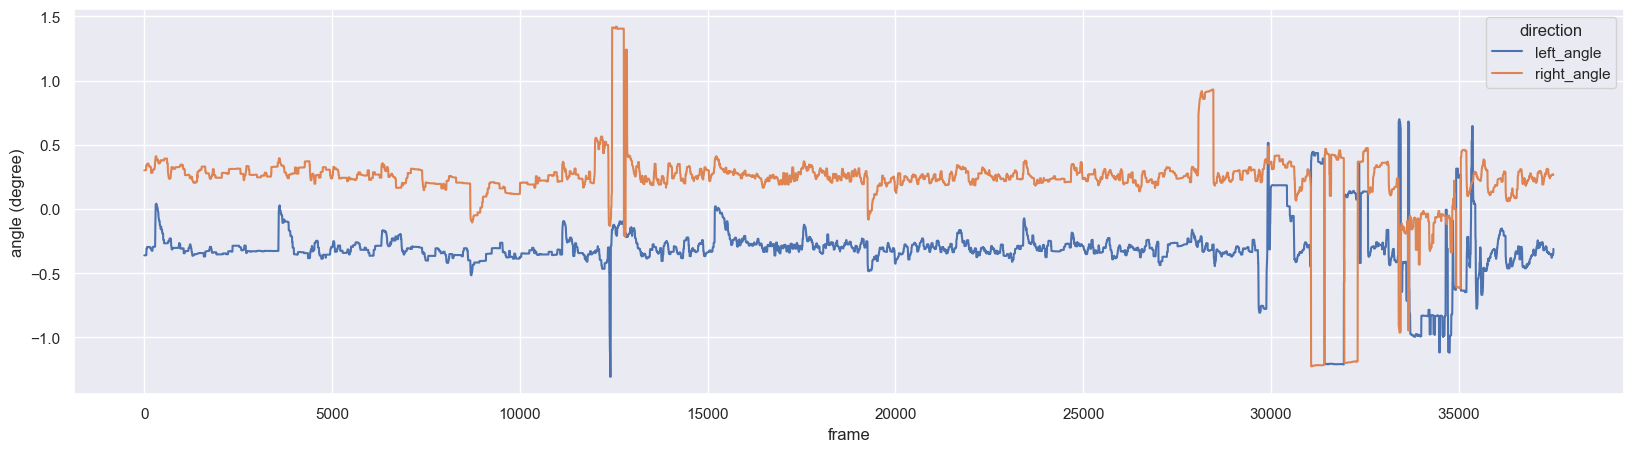

In [84]:
# at the beginning of trial, before introduction of paramecia
sns.lineplot(data=test_kinematics_df1, x='frame', y="angle (degree)", hue="direction", legend="auto")

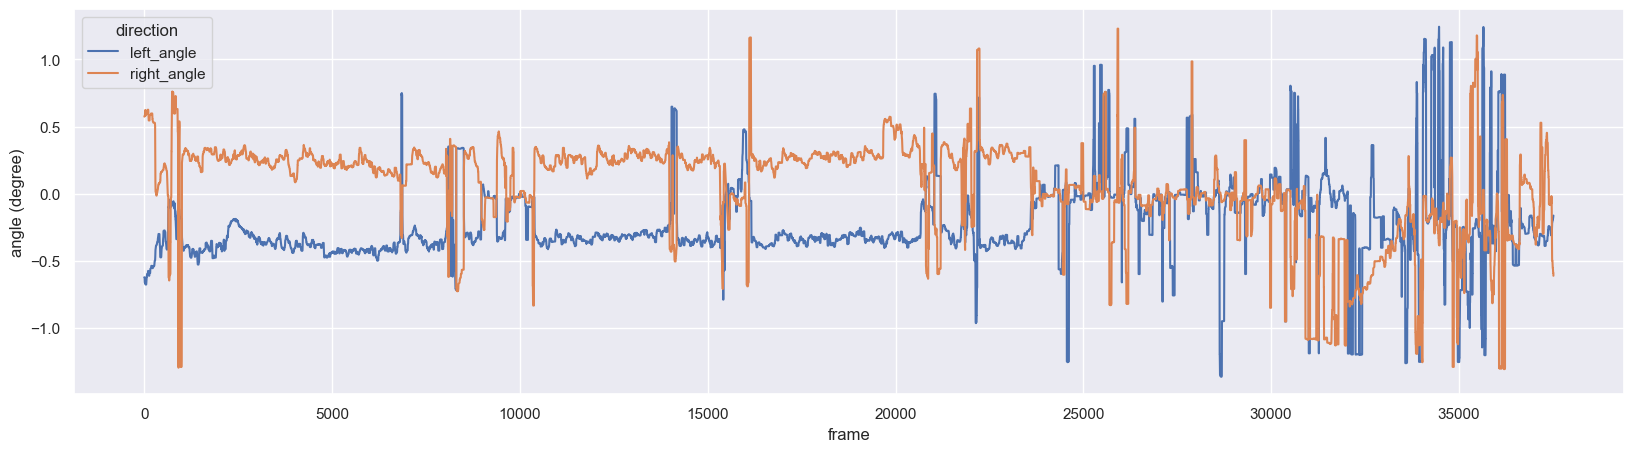

In [85]:
# in the middle of trial, after introduction of paramecia
sns.lineplot(data=test_kinematics_df2, x='frame', y="angle (degree)", hue="direction", legend="auto")

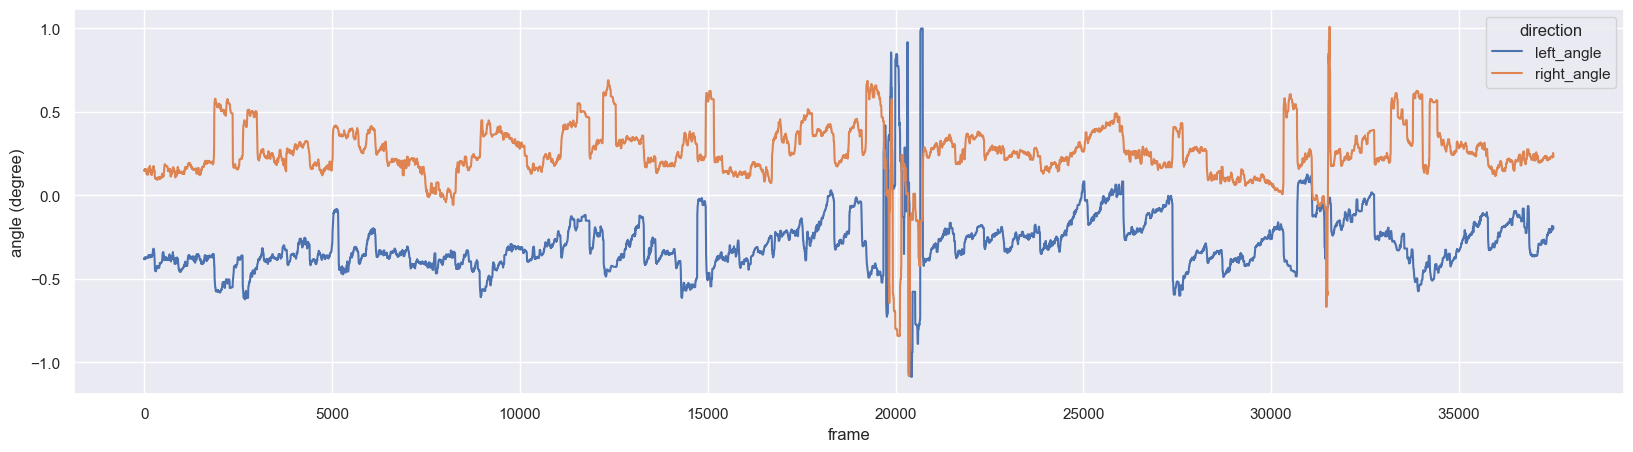

In [86]:
# at the end of the trial, after introduction of paramecia
sns.lineplot(data=test_kinematics_df3, x='frame', y="angle (degree)", hue="direction", legend="auto")

the stuff below for the eye convergence part is still in construction

In [90]:
from behavior_analysis.experiment import BehaviorExperiment
from behavior_analysis.analysis.bouts import BoutData
from behavior_analysis.analysis import eye_convergence
from behavior_analysis.utilities.manage_files_helpers import create_folder
from pathlib import Path
import os

In [91]:
output_directory = create_folder(experiment.subdirs['analysis'], 'eye_convergence')
convergence_scores_path = os.path.join(output_directory, 'convergence_scores.csv')

eye_tracking = eye_convergence.EyeData.from_metadata(experiment.directory.joinpath('fish_data.csv'), experiment.subdirs['kinematics'])

Opening 36 csv files...
##################### 100%
done!
DataFrame has shape: (1350644, 57).
Index levels: ('ID', 'code', 'frame').



In [101]:

for code in bouts_df['code'].unique():
    for ID in bouts_df["ID"].unique():
        kinematics_path = experiment.subdirs['kinematics'].joinpath(ID).joinpath(code + ".csv")
        if os.path.exists(kinematics_path):
            # print(kinematics_path)
            eye_angles = pd.read_csv(kinematics_path, dtype={'ID': str, 'code': str})
eye_angles

,speed,angular_velocity,left_angle,right_angle,k0,k1,k2,k3,k4,k5,...,k43,k44,k45,k46,k47,k48,k49,tip,length,tracked
0,121.090835,0.798119,1.339199,0.666944,-0.042657,0.008125,-0.006945,-0.006510,-0.006510,-0.016671,...,-0.007968,-0.006510,0.002259,0.067534,0.042623,0.112837,0.086344,0.025438,92.448073,True
1,0.000000,0.000000,1.339199,0.666944,-0.041859,0.007327,0.027970,-0.007308,-0.007308,-0.009685,...,-0.008766,-0.007308,0.001461,0.066736,0.041825,0.112039,0.085546,0.024640,92.443737,True
2,66.768911,-0.197165,1.339199,0.666944,0.036433,0.005488,0.036433,-0.009291,-0.009291,-0.009291,...,-0.044337,-0.009291,-0.009291,0.065499,0.040333,0.089846,0.084506,0.013134,91.523883,True
3,66.768911,0.000000,1.339385,0.672730,0.036827,0.005488,0.036827,-0.009291,-0.009291,-0.009291,...,-0.044337,-0.009291,-0.009291,0.065105,0.040333,0.089846,0.084506,0.013095,91.519419,True
4,71.913803,2.301496,1.339571,0.678515,0.036827,0.005488,0.036827,-0.009291,-0.009291,-0.009291,...,-0.044337,-0.009291,-0.009291,-0.000435,0.040333,0.089846,0.084506,0.012771,91.501815,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37513,293.871765,-1.112585,-0.476740,0.336004,-0.031665,-0.055517,-0.058742,-0.047271,-0.085892,-0.014996,...,-0.022521,-0.017221,-0.025184,-0.047271,-0.058742,-0.057742,-0.033890,-0.041057,89.958889,True
37514,242.735831,-2.224339,-0.476188,0.336857,-0.031665,-0.055850,-0.058742,-0.047271,-0.047271,-0.014996,...,-0.022521,-0.017221,-0.025184,-0.047271,-0.058742,-0.055517,-0.031665,-0.040835,89.984609,True
37515,190.391461,0.000000,-0.475939,0.336004,-0.031588,-0.055517,-0.049320,-0.037768,-0.047271,-0.014996,...,-0.028172,-0.037768,-0.034648,-0.014634,0.007480,-0.051068,0.023138,-0.027998,89.011731,True
37516,166.392218,-0.157526,-0.475690,0.336857,-0.031588,-0.055850,0.003965,-0.018528,-0.074849,-0.032300,...,-0.032300,-0.042823,-0.034648,-0.014634,0.007480,0.028607,0.023138,-0.022210,90.238756,True


In [107]:
eye_data = eye_convergence.EyeData.from_metadata(bouts_df, experiment.subdirs['kinematics'])
eye_data

Opening 36 csv files...
##################### 100%
done!
DataFrame has shape: (1350644, 57).
Index levels: ('ID', 'code', 'frame').



In [108]:
convergence = eye_convergence.calculate_convergence(eye_data)

TypeError: 'EyeData' object is not subscriptable

In [ ]:
plots_directory = create_folder(output_directory, 'plots')
convergence_scores = eye_convergence.EyeConvergenceAnalysis.calculate_convergence_score(eye_data)
convergence_scores.to_csv(convergence_scores_path, index=False)
eye_convergence.EyeConvergenceAnalysis.plot_histogram(convergence_scores, output_path= plots_directory)

AttributeError: 'EyeData' object has no attribute 'convergence'

In [18]:
bouts_path = os.path.join(experiment.subdirs['analysis'], 'bouts.csv')
bouts_df = pd.read_csv(bouts_path, index_col=0, dtype={'ID': str, 'video_code': str})

eye_convergence_directory = os.path.join(experiment.subdirs['analysis'], 'eye_convergence')
convergence_scores_path = os.path.join(eye_convergence_directory, 'convergence_scores.csv')

convergence_scores = pd.read_csv(convergence_scores_path, dtype={'ID': str})

frame_rate = 500.
window = int(0.02 * 500)

# Import bout data
bouts = BoutData.from_directory(bouts_df, experiment.subdirs['kinematics'],
                                check_tail_lengths=False, tail_columns_only=False)

print_heading('CLASSIFYING BOUTS')
convergence_states = np.empty((len(bouts_df), 4))
i = 0
for idx, fish_info in convergence_scores.iterrows():
    print(fish_info.ID)
    for bout in bouts.list_bouts(IDs=[fish_info.ID]):
        bout_convergence = np.degrees(bout['right'] - bout['left'])
        convergence_start = bout_convergence[:window].mean()
        convergence_end = bout_convergence[-window:].mean()
        convergence_states[i, :2] = np.array([convergence_start, convergence_end])
        convergence_states[i, 2:] = (np.array([convergence_start, convergence_end]) >= fish_info.threshold)
        i += 1
assert i == len(convergence_states), 'Incorrect number of bouts!'
np.save(os.path.join(eye_convergence_directory, 'convergence_states.npy'), convergence_states)

FileNotFoundError: [Errno 2] File C:\Users\manyung.ng\Documents\behaviour_analysis\behavior_analysis_tracking\test_analysis\analysis\eye_convergence\convergence_scores.csv does not exist: 'C:\\Users\\manyung.ng\\Documents\\behaviour_analysis\\behavior_analysis_tracking\\test_analysis\\analysis\\eye_convergence\\convergence_scores.csv'